# Tutorial 2 : Neural Processes - 1D GP Data

Last Update : 12 June 2019

**Aim**: 
- Training a simple [Neural Process]
- See how well a NP "learns" a GP kernel

**Nota Bene:**
- Much more details about the framework and dataset can be found in [Tutorial 1 - Conditional Neural Process].
- Not much hyperparameter optimization done
- Architecture differs slightly from the paper to be more general and modularizable for future work.


[Neural Process]: https://arxiv.org/abs/1807.01622
[Conditional Neural Process]: https://arxiv.org/pdf/1807.01613.pdf
[Attentive Neural Process]: https://arxiv.org/abs/1901.05761
[Image Transformer]: https://arxiv.org/abs/1802.05751
[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb
[Tutorial 2 - Neural Process]: Tutorial%202%20-%20Neural%20Process.ipynb
[Tutorial 3 - Attentive Neural Process]: Tutorial%203%20-%20Attentive%20Neural%20Process.ipynb

**Environment Hypermarameters:**

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/master


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

The dataset we will be using are simple functions sampled from different Gaussian kernel. See [Tutorial 1 - Conditional Neural Process] for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [4]:
X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
N_POINTS = 128
N_SAMPLES = 100000 # this is a lot and can work with less

In [5]:
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, DotProduct, ConstantKernel
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

from ntbks_datasets import GPDataset

datasets = dict()
kwargs = dict(n_samples=N_SAMPLES, n_points=N_POINTS)
datasets["rbf"] = GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                             length_scale_bounds=(1e-1, 10.0)),
                            **kwargs)

datasets["periodic"] = GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                             periodicity=3.0,
                                                             length_scale_bounds=(0.1, 10.0),
                                                             periodicity_bounds=(1.0, 10.0)),
                                 **kwargs)
datasets["non-stationary"] = GPDataset(kernel=(ConstantKernel(0.1, (0.01, 10.0)) *
                                               (DotProduct(sigma_0=1.0,
                                                           sigma_0_bounds=(0.1, 10.0)) ** 2)),
                                       **kwargs)
datasets["matern"] = GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                   length_scale_bounds=(1e-1, 10.0),
                                                   nu=1.5),
                               **kwargs)

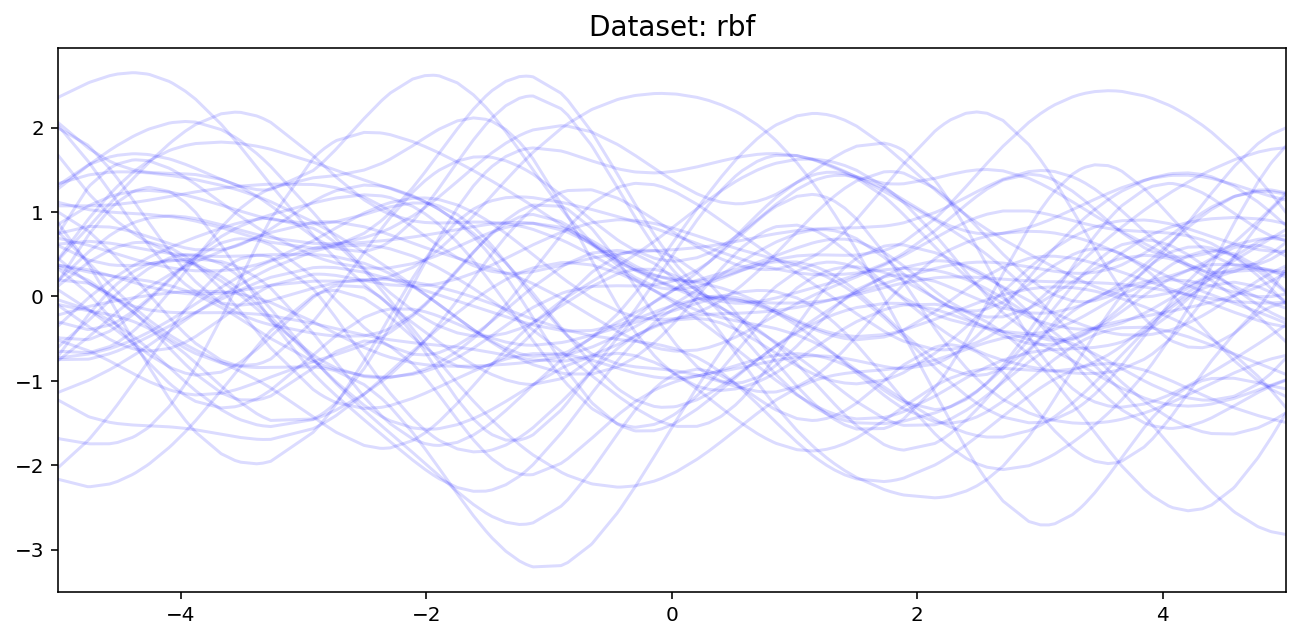

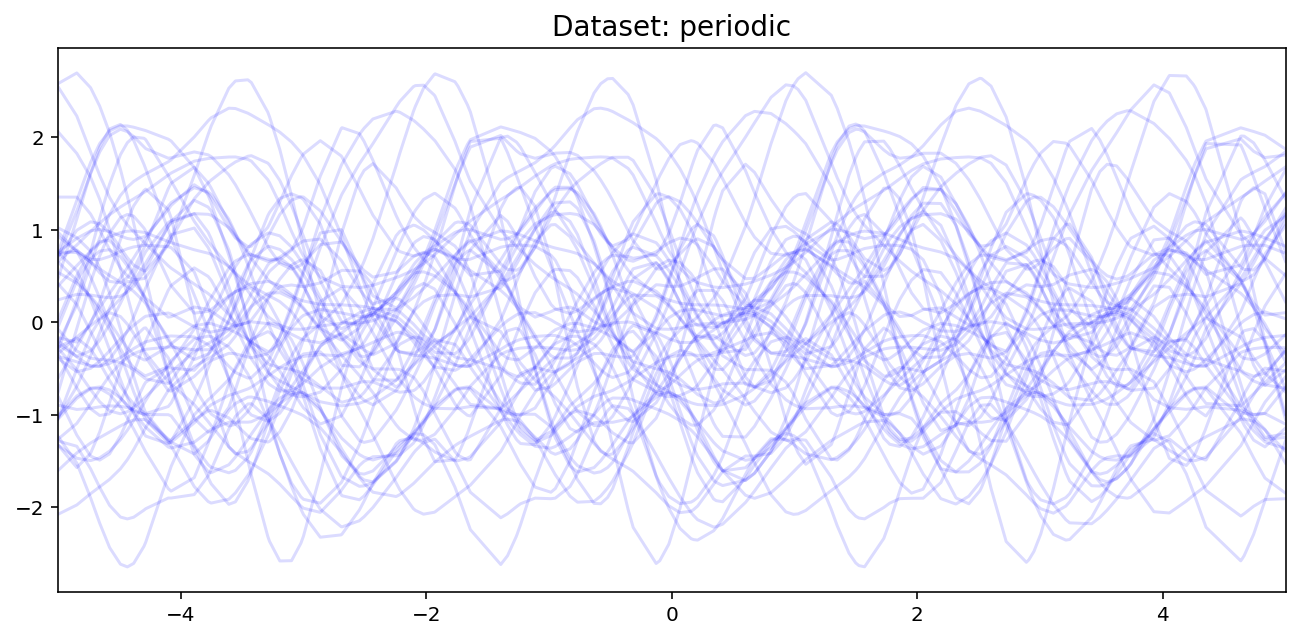

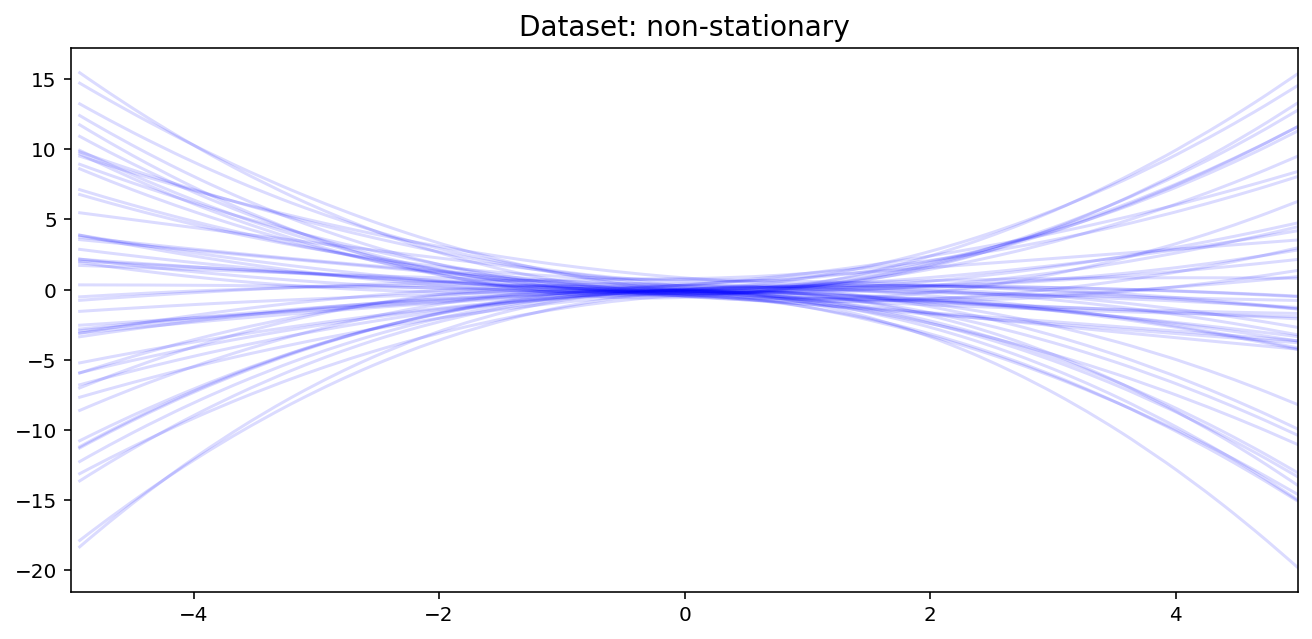

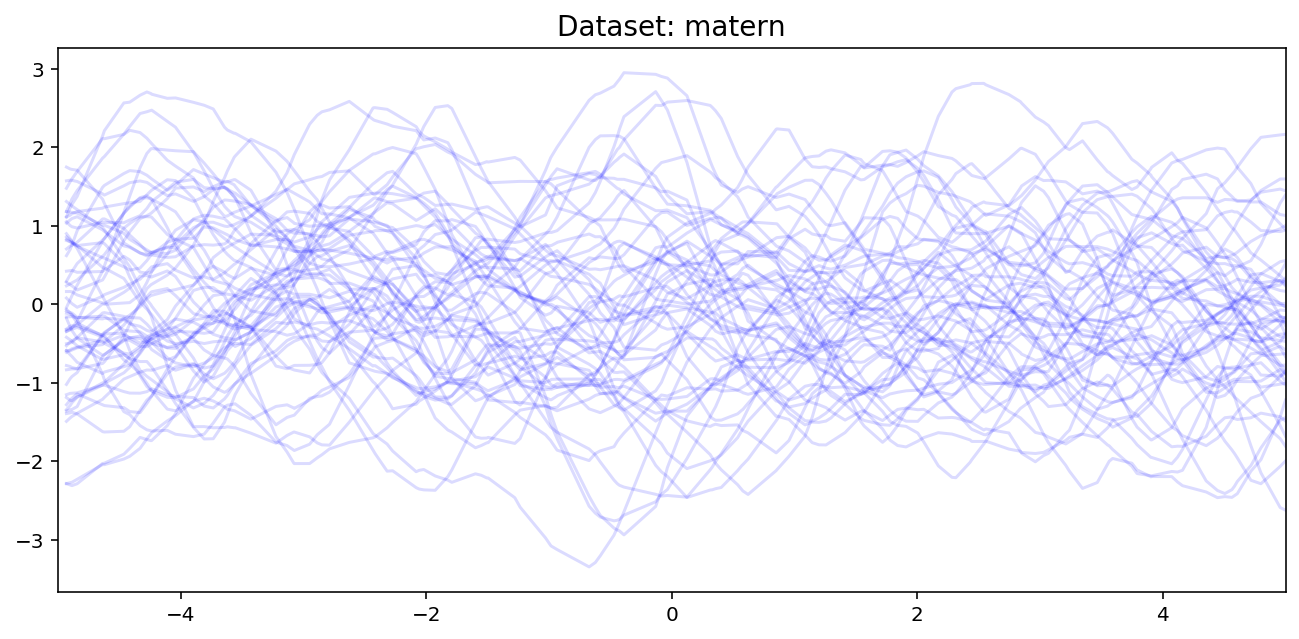

In [6]:
for k, dataset in datasets.items():
    plot_dataset_samples(dataset, title="Dataset: {}".format(k))

## Model

The general model architecture is slightly different from the paper to make it modular and easy to extend, but it is easy to make them equivalent with the right parameters. Refer to [Tutorial 1 - Conditional Neural Process] for an overview main parameters or the docstrings of `NeuralProcess` for all parameters. 

Differences with [Tutorial 1 - Conditional Neural Process]:
- `encoded_path="latent"`

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [7]:
R_DIM = 128
RANGE_CNTXT = (4, 50)  # context points will be sampled uniformly in this range
RANGE_EXTRA_TRGTS = (3, N_POINTS-RANGE_CNTXT[1])  # extra number of targtes points 

In [8]:
from torch.distributions import Normal

from skssl.transformers import (NeuralProcessLoss, NeuralProcess, AttentiveNeuralProcess, 
                                SelfAttentionBlock, SinusoidalEncodings)
from skssl.predefined import MLP, merge_flat_input, get_uninitialized_mlp
from skssl.transformers.neuralproc.datasplit import context_target_split

def get_cntxt_trgt(*args):
    return context_target_split(*args, range_cntxts=RANGE_CNTXT, range_extra_trgts=RANGE_EXTRA_TRGTS)

def init_model():
    return NeuralProcess(X_DIM, Y_DIM,
                         XEncoder=MLP, # no sinusoidal encodings
                         XYEncoder=merge_flat_input(get_uninitialized_mlp(n_hidden_layers=2),
                                                    is_sum_merge=True),  # sum the encoded X and Y 
                         Decoder=merge_flat_input(get_uninitialized_mlp(n_hidden_layers=4),
                                                  is_sum_merge=True),  # sum the encoded X and Y  
                         r_dim=R_DIM,
                         get_cntxt_trgt=get_cntxt_trgt,
                         aggregator=torch.mean,
                         PredictiveDistribution=Normal, 
                         LatentEncoder=MLP,
                         encoded_path="latent") # use NP

# initialize one model for each dataset
data_models = {name: (init_model(), data) 
               for name, data in datasets.items()}

/master/skssl/predefined/mlp.py:56: UserWarning: hidden_size=32 smaller than output=128 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/skssl/predefined/mlp.py:56: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


### N Param

Number of parameters (note that I did not play around with this much, this depends a lot on the representation size):

In [9]:
from utils.helpers import count_parameters

for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break

N Param: 148034


More parameters than CNP because need a MLP that maps $R \to Z$

# Training

In [13]:
N_EPOCHS = 50 # 30 is enough
BATCH_SIZE = 64
is_RETRAIN = False # if false load precomputed

In [14]:
from skorch.callbacks import ProgressBar, Checkpoint

from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- {} {} ---".format("Training" if is_RETRAIN else "Loading", k))
    print()
    
    chckpt = Checkpoint(dirname="results/notebooks/neural_process/np_{}".format(k), 
                        monitor='train_loss_best') # train would be same as validation as always resamples
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=N_EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 train_split=None,  # don't use cross validation dev set
                                 lr=1e-3, # they use 5e-5 because 16 batch size but that would be slow
                                 callbacks=[ProgressBar(), 
                                            chckpt], # checkpoint best model
                                ) 
    
    if is_RETRAIN:
        _=model.fit(*make_Xy_input(dataset))
    
    # load in all case => even when training loads the best checkpoint
    model.initialize()
    model.load_params(checkpoint=chckpt)


--- Training rbf ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1      111.0378     +  26.9396


      2       61.1224     +  24.3483


      3       33.9512     +  28.0079


      4       13.7218     +  25.7400


      5       -3.4166     +  26.4804


      6      -20.8261     +  28.9504


      7      -30.8103     +  28.1410


      8      -36.6158     +  27.4987


      9      -42.7165     +  28.5947


     10      -45.7153     +  28.8208


     11      -49.0213     +  27.5901


     12      -53.8572     +  27.9503


     13      -53.7483        28.6576


     14      -58.9758     +  26.9637


     15      -71.6479     +  28.3360


     16      -74.1261     +  28.6613


     17      -77.4618     +  28.5009


     18      -75.9853        35.8837


     19      -78.4952     +  35.4935


     20      -81.6586     +  36.0135


     21      -80.4091        35.9321


     22      -80.5053        35.8948


     23      -78.5044        35.7539


     24      -81.7797     +  35.4551


     25      -81.6265        34.8388


     26      -83.3128     +  35.4161


     27      -83.6761     +  32.4492


     28      -84.3628     +  28.6731


     29      -86.7724     +  27.9281


     30      -86.3685        27.4414


     31      -93.1555     +  28.6130


     32      -96.3205     +  29.7635


     33      -95.1376        28.6369


     34      -93.8904        27.6189


     35      -98.7396     +  29.1527


     36      -95.1787        27.9590


     37      -99.8658     +  27.6361


     38     -101.4364     +  28.8945


     39     -101.4317        27.8807


     40      -99.5686        29.1482


     41      -99.8738        29.2851


     42      -99.2962        28.7595


     43     -102.1348     +  27.1560


     44     -103.0402     +  29.4298


     45     -104.3489     +  29.5788


     46     -103.2464        29.3696


     47     -105.8078     +  28.1979


     48     -103.1042        27.6665


     49     -101.8634        28.8717


     50     -104.6246        29.3074
Re-initializing optimizer because the following parameters were re-set: .

--- Training periodic ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1      132.2815     +  28.5372


      2      128.2336     +  28.9856


      3      127.7116     +  29.3215


      4      127.5048     +  28.7741


      5      127.0123     +  27.8020


      6      111.7036     +  33.4228


      7       91.9561     +  33.5562


      8       84.7040     +  34.2856


      9       80.4911     +  33.4470


     10       76.5689     +  34.5730


     11       66.3327     +  33.8148


     12       45.9678     +  33.9041


     13       37.6268     +  34.0699


     14       20.9141     +  33.8387


     15       12.4210     +  34.5410


     16        8.0574     +  34.6921


     17        4.7830     +  33.8859


     18       -0.6822     +  34.1875


     19       -4.8158     +  34.4612


     20       -4.3902        34.2877


     21       -5.4676     +  33.4076


     22      -13.7221     +  33.9557


     23      -12.8774        33.3712


     24      -18.1978     +  33.7266


     25      -19.0218     +  34.3212


     26      -22.4574     +  34.3716


     27      -34.8673     +  33.8027


     28      -41.3653     +  33.6991


     29      -48.1799     +  32.8615


     30      -49.3959     +  33.8907


     31      -49.7099     +  33.8402


     32      -53.0994     +  33.8103


     33      -52.4918        33.8626


     34      -55.1315     +  28.5563


     35      -53.7496        28.6191


     36      -55.7043     +  28.5932


     37      -56.5128     +  29.2962


     38      -57.1504     +  29.7090


     39      -60.3666     +  30.3795


     40      -62.3335     +  33.5501


     41      -57.4553        32.1859


     42      -60.1274        32.7553


     43      -67.6469     +  32.6484


     44      -62.3838        32.6939


     45      -60.4945        32.5827


     46      -62.7730        32.8709


     47      -69.9945     +  32.5385


     48      -64.2557        33.2663


     49      -61.4542        31.8381


     50      -64.7144        33.5232
Re-initializing optimizer because the following parameters were re-set: .

--- Training non-stationary ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1      790.7008     +  32.5113


      2       52.6131     +  33.0988


      3       15.7260     +  32.4594


      4       -5.1804     +  29.1068


      5      -17.8667     +  28.3248


      6      -28.5950     +  25.7401


      7      -38.5956     +  28.2436


      8      -40.7052     +  28.1992


      9      -45.3756     +  29.0104


     10      -54.3545     +  29.3169


     11      -60.7861     +  28.5269


     12      -63.5754     +  29.4411


     13      -69.3909     +  27.1316


     14      -75.9750     +  27.9166


     15      -77.9127     +  29.2615


     16      -80.5208     +  27.7528


     17      -80.3211        27.9393


     18      -83.4564     +  29.0078


     19      -89.6744     +  28.4959


     20      -90.7818     +  26.5273


     21      -92.8381     +  28.0511


     22      -94.0875     +  28.6619


     23      -95.7400     +  29.8578


     24      -98.1721     +  28.4904


     25     -100.1769     +  29.2978


     26     -102.5840     +  27.3832


     27     -101.1151        29.1671


     28     -101.2399        27.5180


     29     -100.2232        27.2968


     30     -102.7442     +  26.6575


     31     -104.9134     +  28.2865


     32     -107.7719     +  28.5625


     33     -106.6386        29.0767


     34     -107.5919        27.4356


     35     -109.6501     +  27.5502


     36     -107.5416        28.4730


     37     -112.8419     +  26.5677


     38     -113.5391     +  25.1766


     39     -111.0131        27.9676


     40     -112.3009        26.7860


     41     -114.0815     +  28.5480


     42     -116.3129     +  27.7828


     43     -120.1351     +  26.3692


     44     -118.0441        29.0930


     45     -114.6611        29.0333


     46     -119.7539        27.1023


     47     -121.2333     +  27.7507


     48     -116.4819        25.8597


     49     -123.1933     +  25.7851


     50     -119.7235        27.7304
Re-initializing optimizer because the following parameters were re-set: .

--- Training matern ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1      133.6381     +  28.7922


      2       98.8663     +  26.2312


      3       80.9620     +  24.4297


      4       73.9278     +  25.1662


      5       64.0110     +  25.5985


      6       54.1395     +  28.9792


      7       46.3619     +  27.9207


      8       41.0516     +  29.2042


      9       37.5628     +  28.3065


     10       32.2994     +  29.3451


     11       27.3279     +  27.2687


     12       24.8387     +  28.2160


     13       24.0355     +  28.0882


     14       22.0050     +  31.8747


     15       19.9666     +  33.7397


     16       16.4926     +  31.5454


     17       14.2153     +  31.8517


     18       13.1092     +  33.9221


     19       11.1506     +  34.2170


     20        9.0727     +  32.6320


     21       10.5075        33.8200


     22        9.3794        34.1698


     23        9.5189        32.8581


     24        7.5512     +  32.9558


     25        6.4648     +  33.4198


     26        6.5574        33.8616


     27        5.5922     +  33.3979


     28        7.1988        33.6397


     29        5.7738        33.4628


     30        4.3578     +  33.5059


     31        4.1144     +  33.5660


     32        4.3890        34.6305


     33        3.4702     +  33.7399


     34        3.3807     +  34.2440


     35        1.8813     +  32.2767


     36        1.3770     +  33.7541


     37        0.0070     +  32.4992


     38       -1.1492     +  33.6039


     39       -3.4783     +  34.4087


     40       -3.6685     +  33.4509


     41       -4.0106     +  33.5816


     42       -2.9269        33.9800


     43       -5.4960     +  33.2199


     44       -5.8213     +  33.6255


     45       -5.5360        32.7837


     46       -5.5771        34.3368


     47       -7.4284     +  33.5275


     48       -6.1555        33.4538


     49       -6.3935        34.5378


     50       -7.2473        33.3832
Re-initializing optimizer because the following parameters were re-set: .


# Trained Prior

In [15]:
EXTRAP_DISTANCE = 2  # add 2 to the right for extrapolation
INTERPOLATION_RANGE = dataset.min_max
EXTRAPOLATION_RANGE = (dataset.min_max[0], dataset.min_max[1]+EXTRAP_DISTANCE )

std: 0.667558808326721
std: 3.1503303599357597
std: 0.17356131434440616
std: 1.1615960282087328


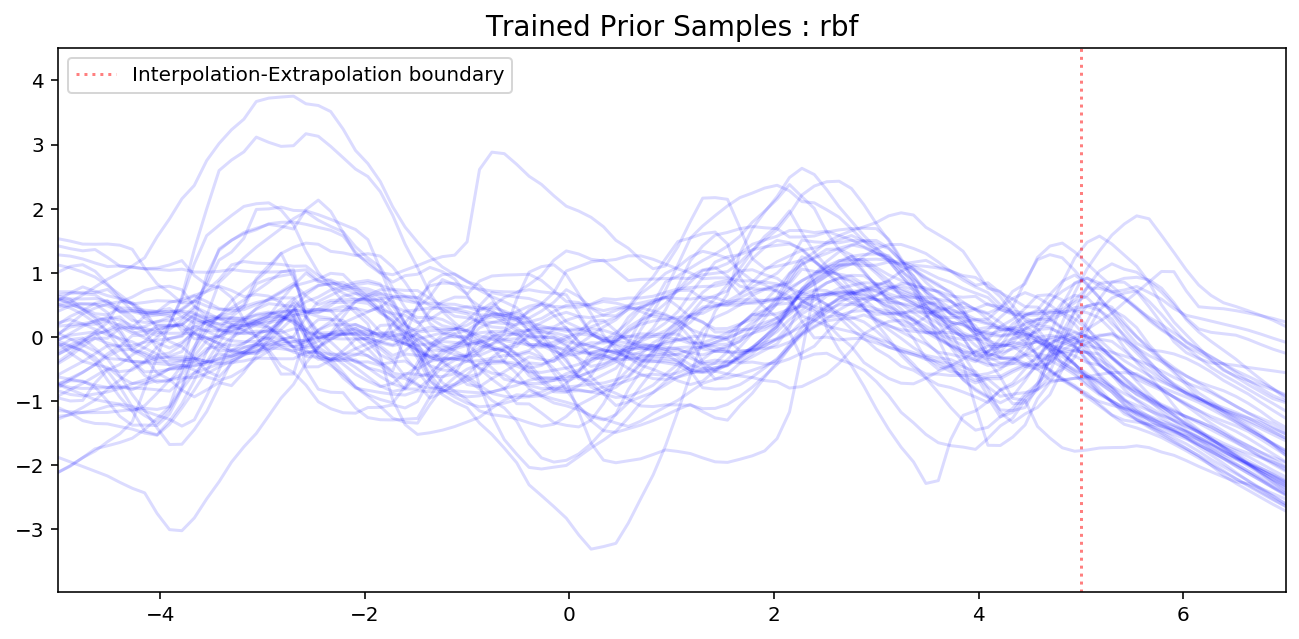

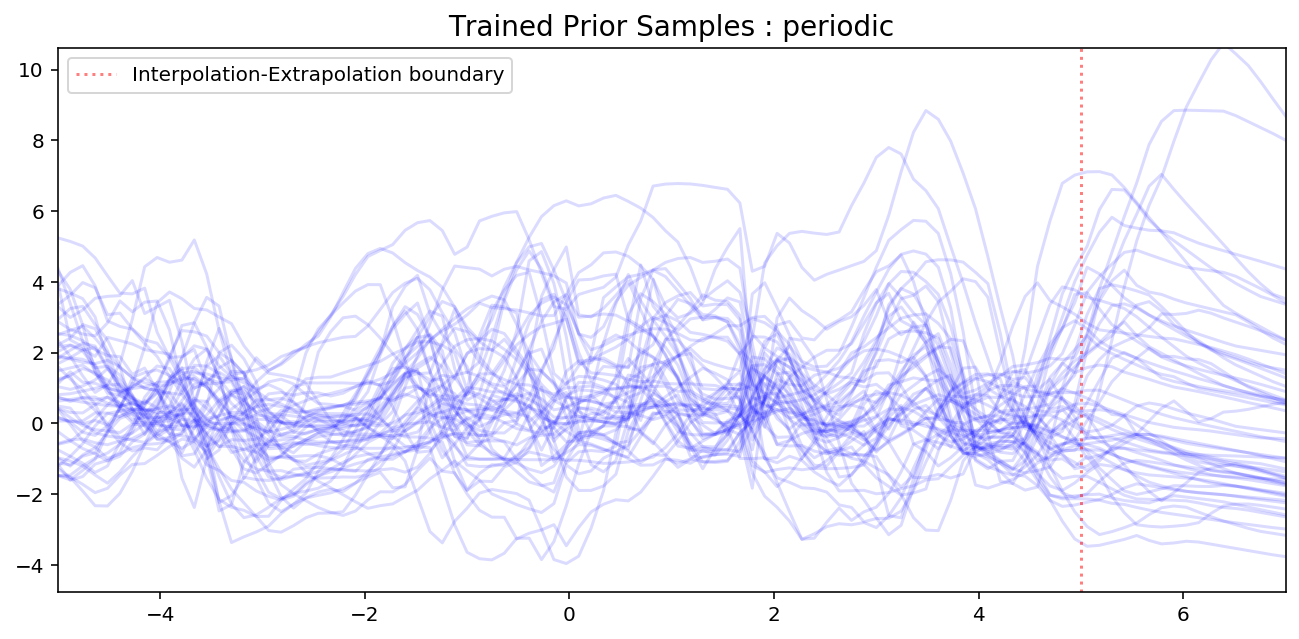

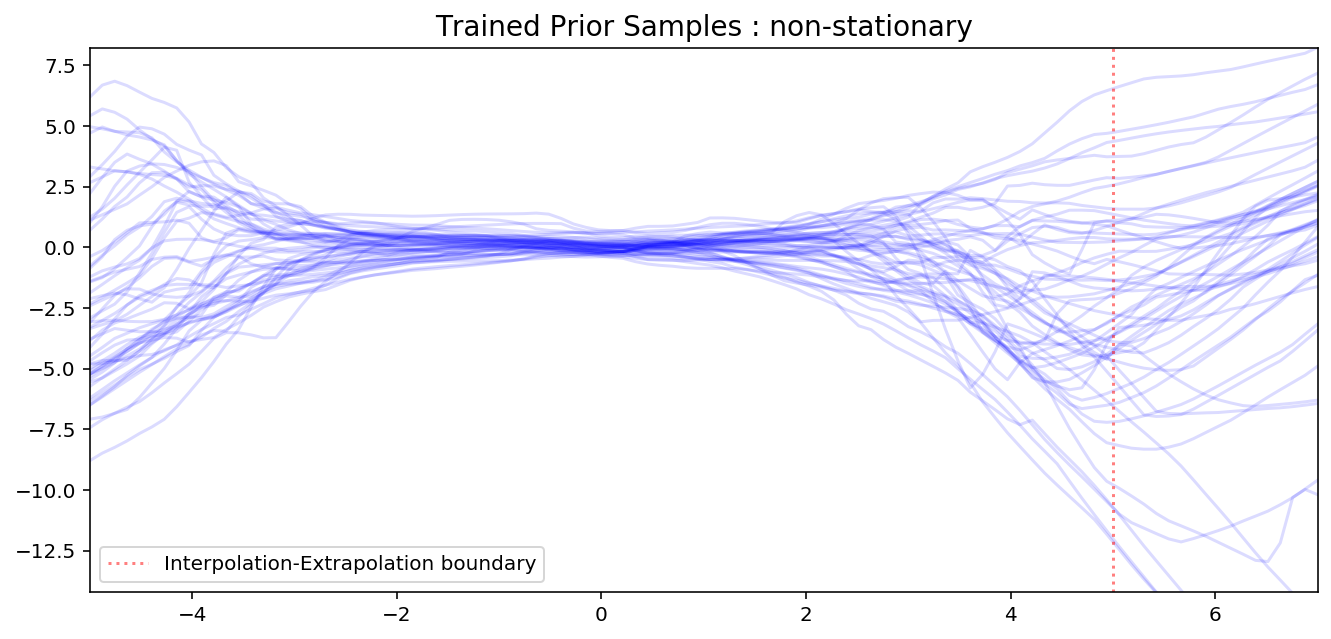

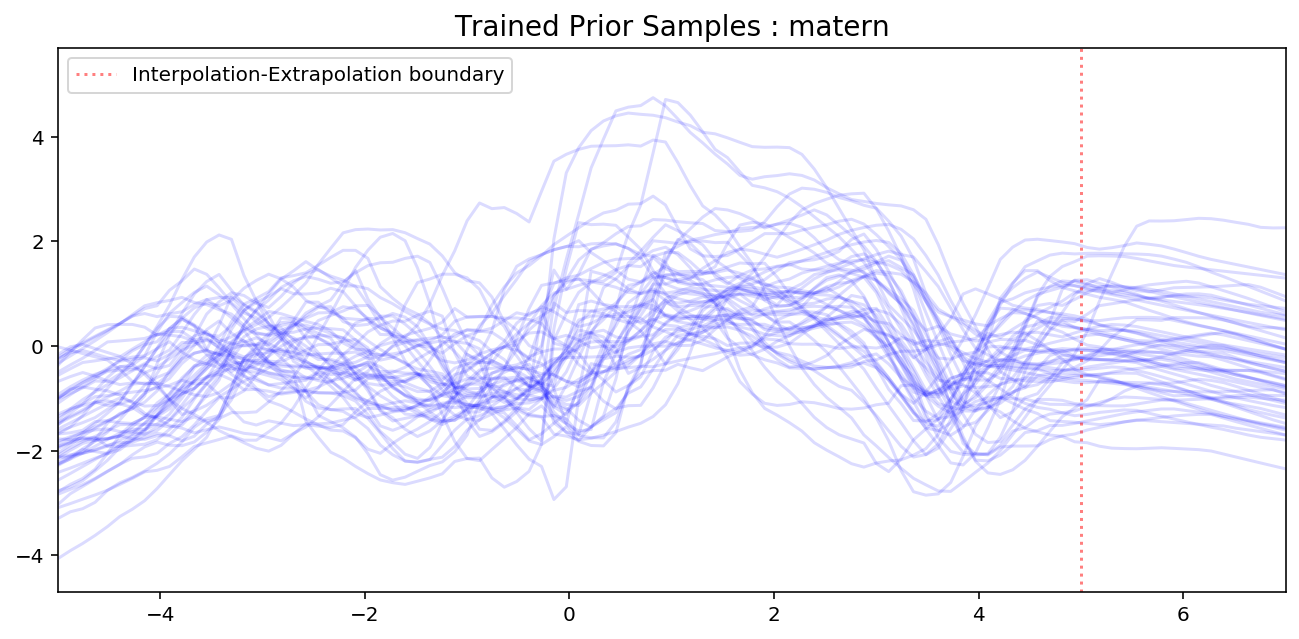

In [16]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, 
                       title="Trained Prior Samples : {}".format(k), 
                       test_min_max=EXTRAPOLATION_RANGE, 
                       train_min_max=INTERPOLATION_RANGE)

Note that we already see from the unconditioned prior samples, that extrapolation will not work well.

# Posterior

std: 0.8256825351715089
std: 1.3094656348228453
std: 0.1537048295140267
std: 0.9579585027694701


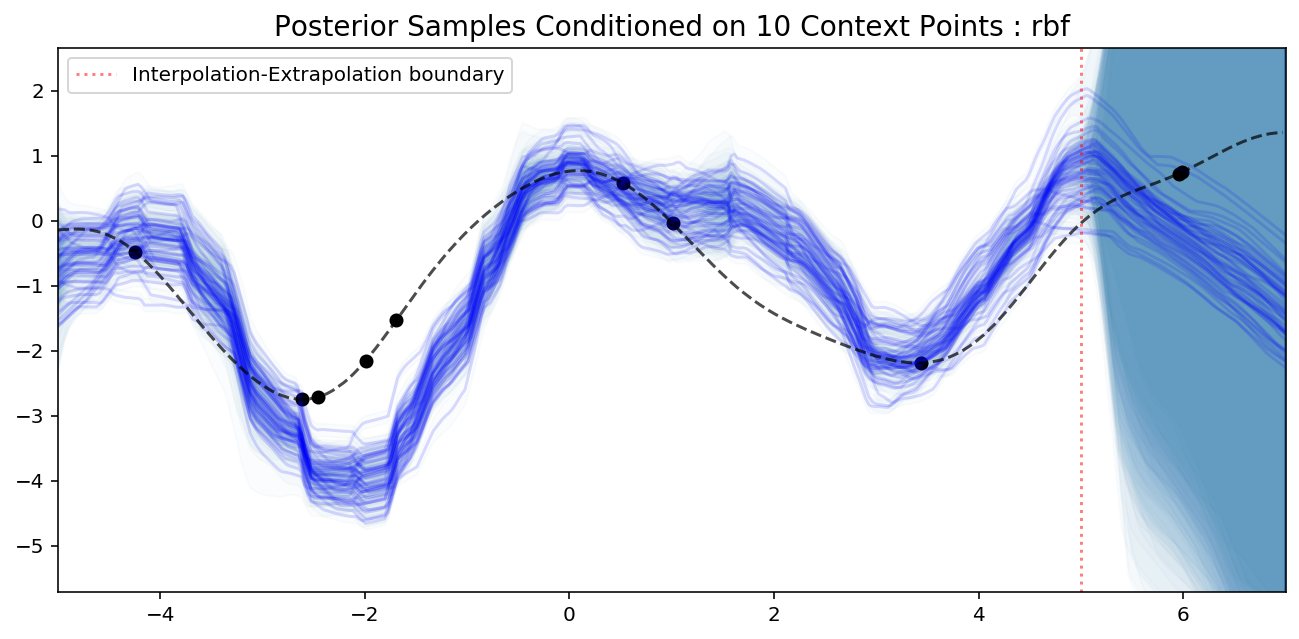

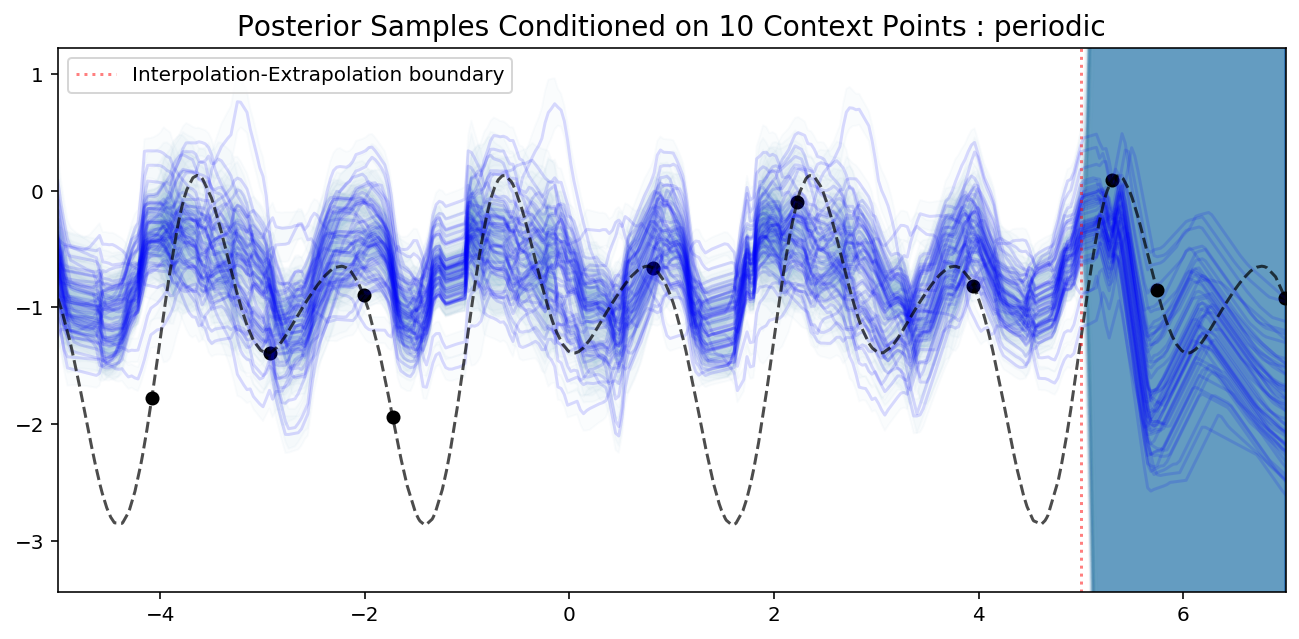

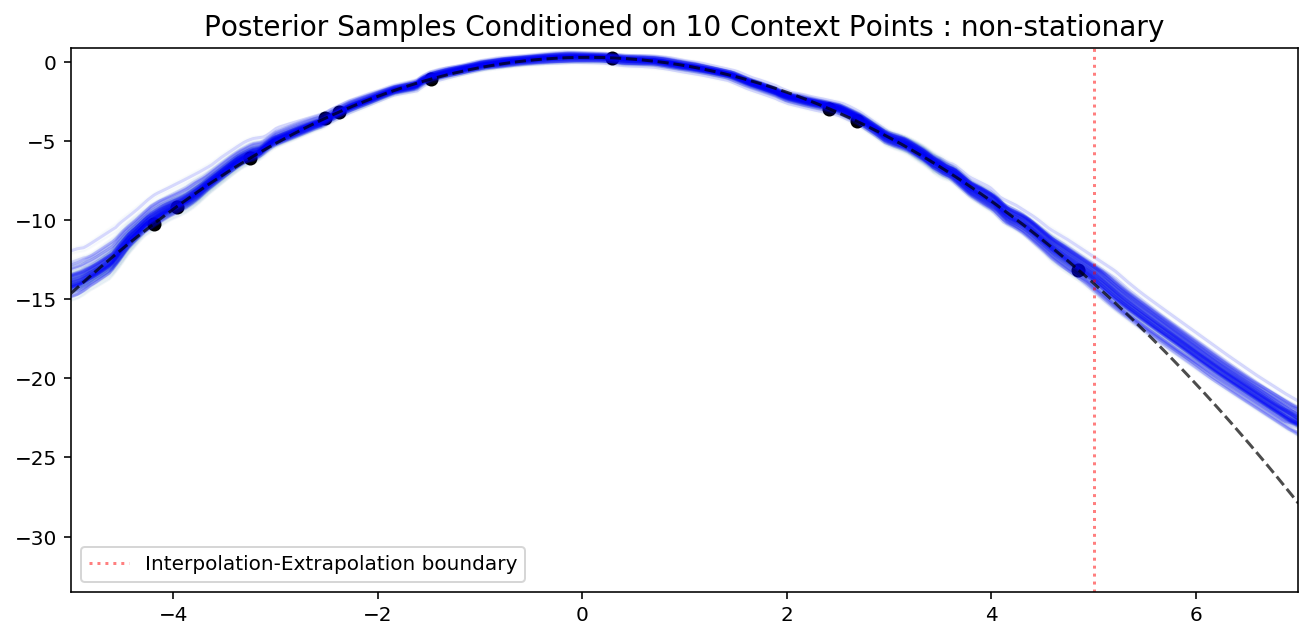

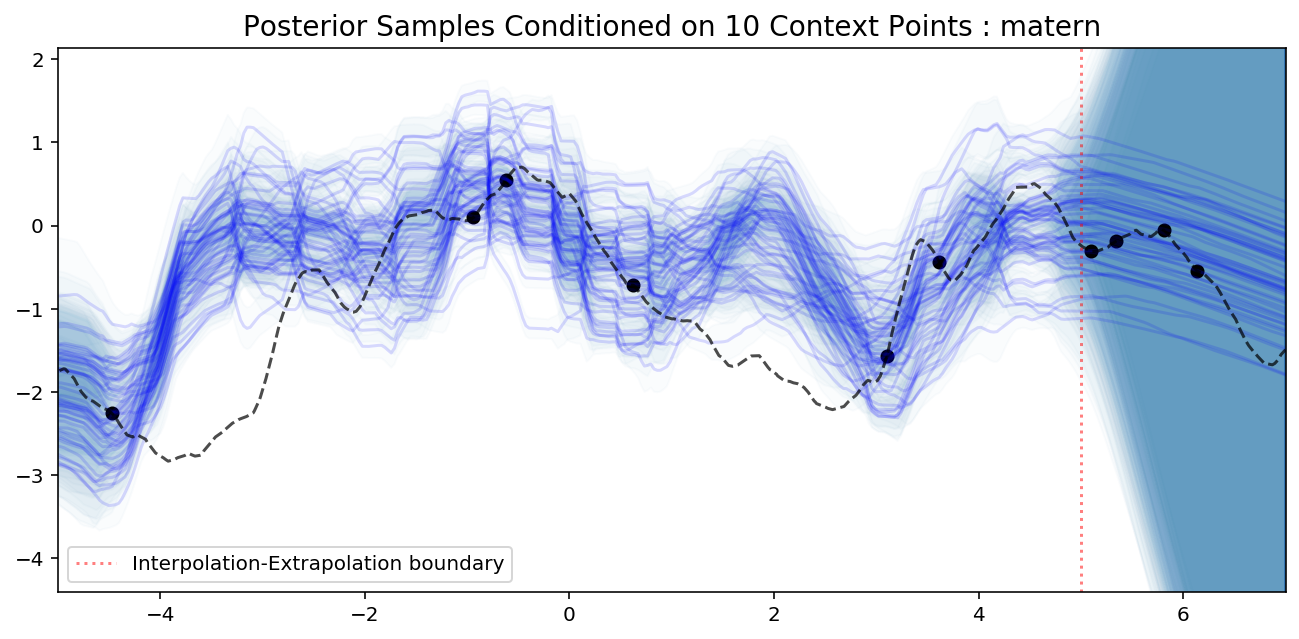

In [17]:
N_CNTXT = 10
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=3*N_POINTS,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

std: 0.99889288743337
std: 1.3971976558367412
std: 0.17651341756184893
std: 0.9759116510550181


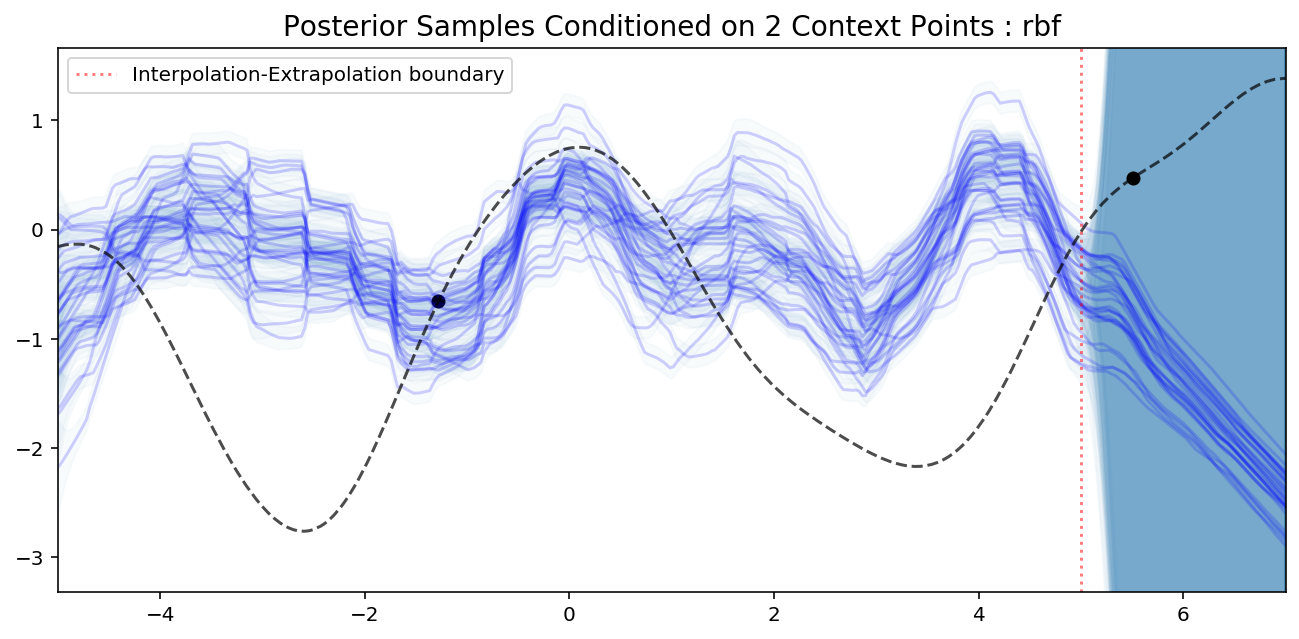

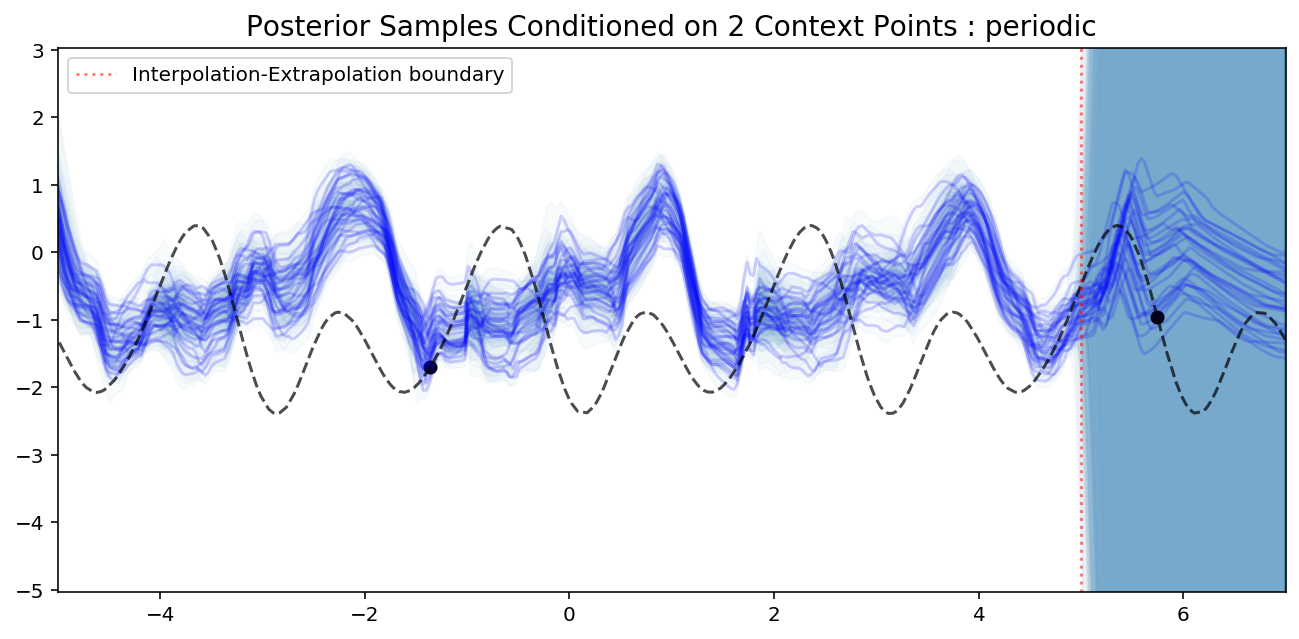

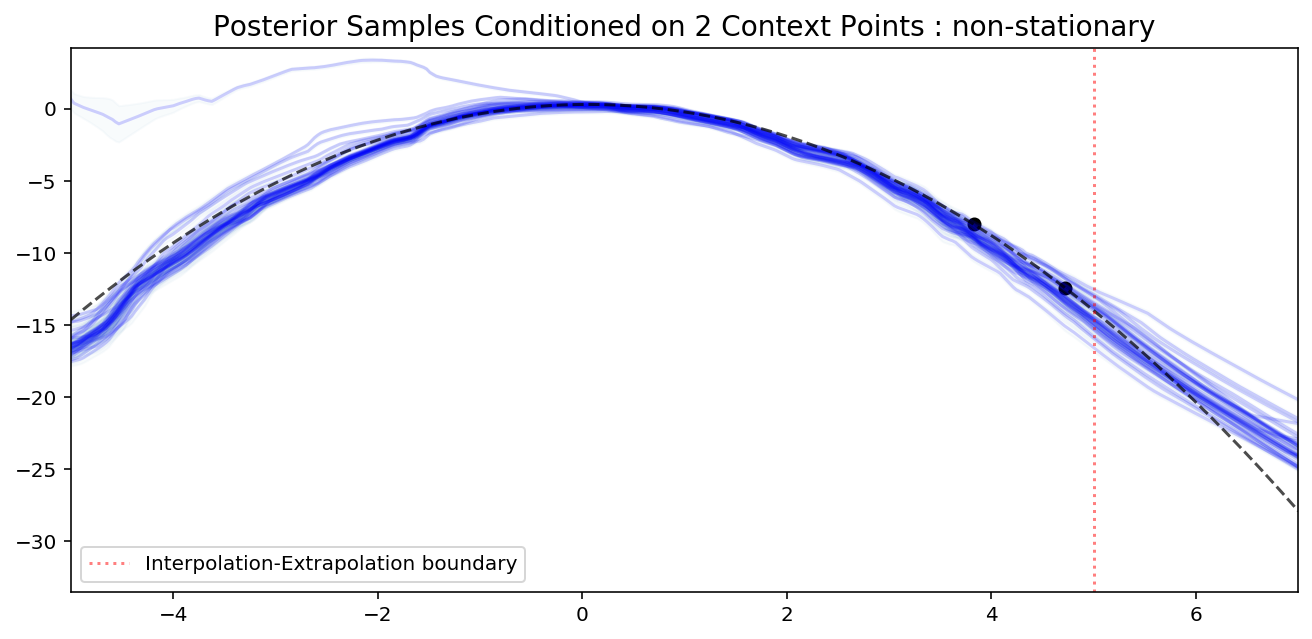

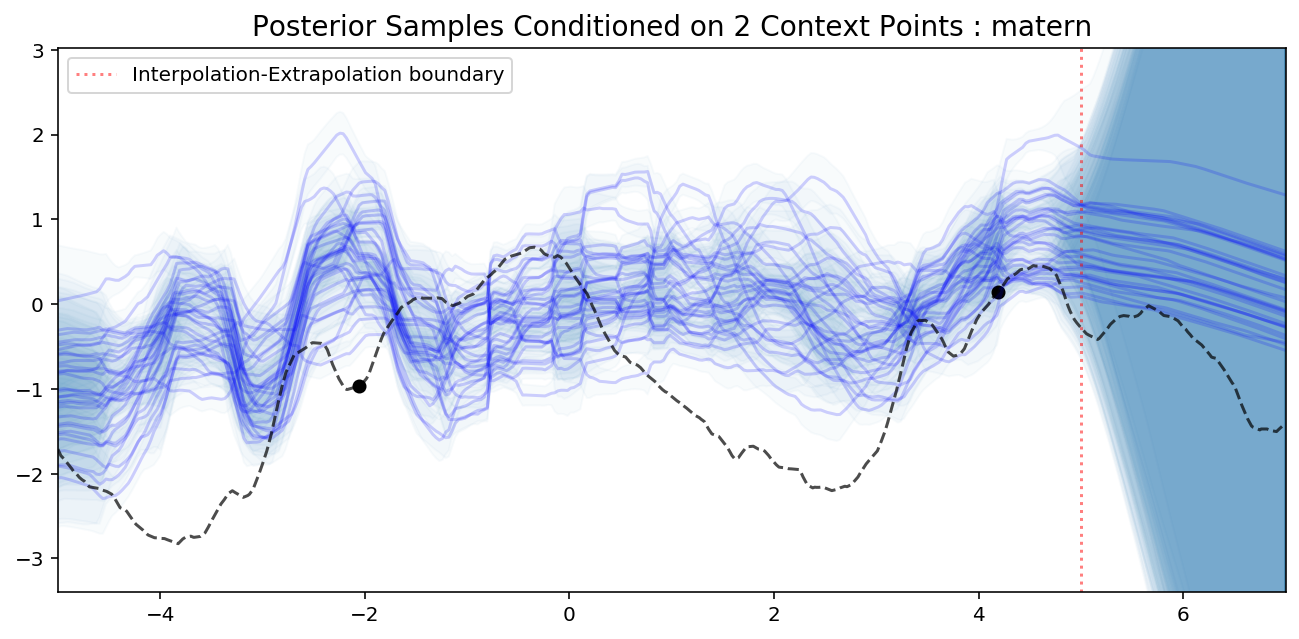

In [18]:
N_CNTXT = 2
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=3*N_POINTS,
                           n_samples=30,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

std: 0.8613513481616973
std: 1.405088219642639
std: 0.1655177000164985
std: 0.9678322494029996


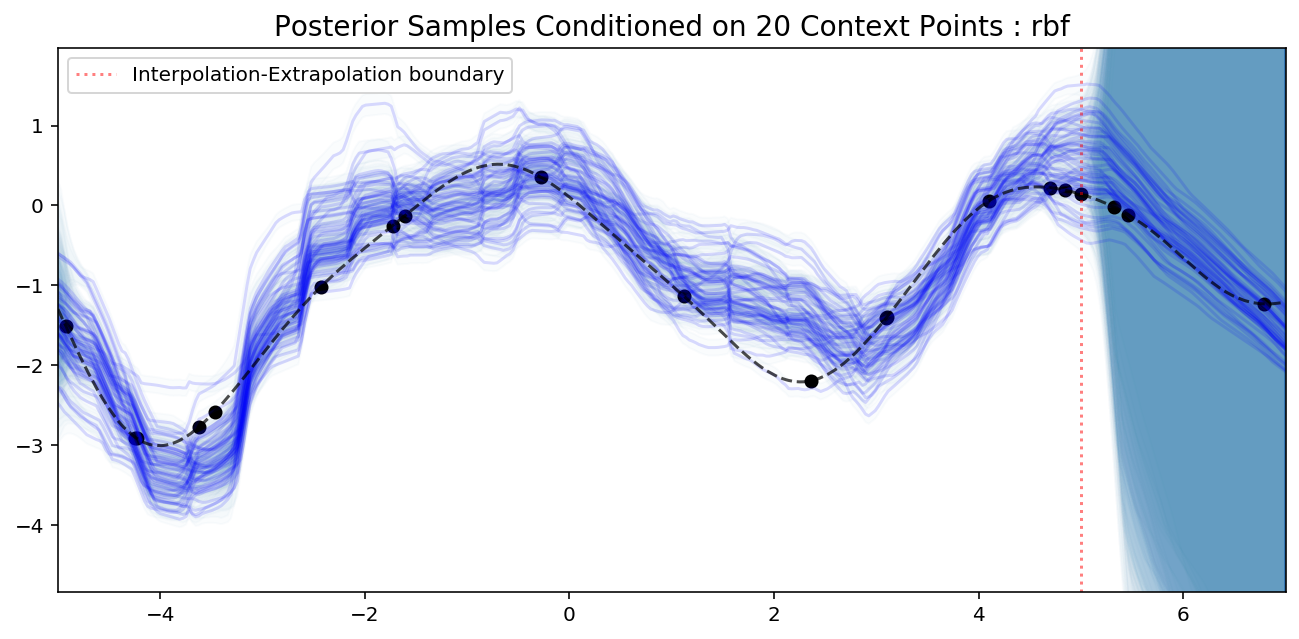

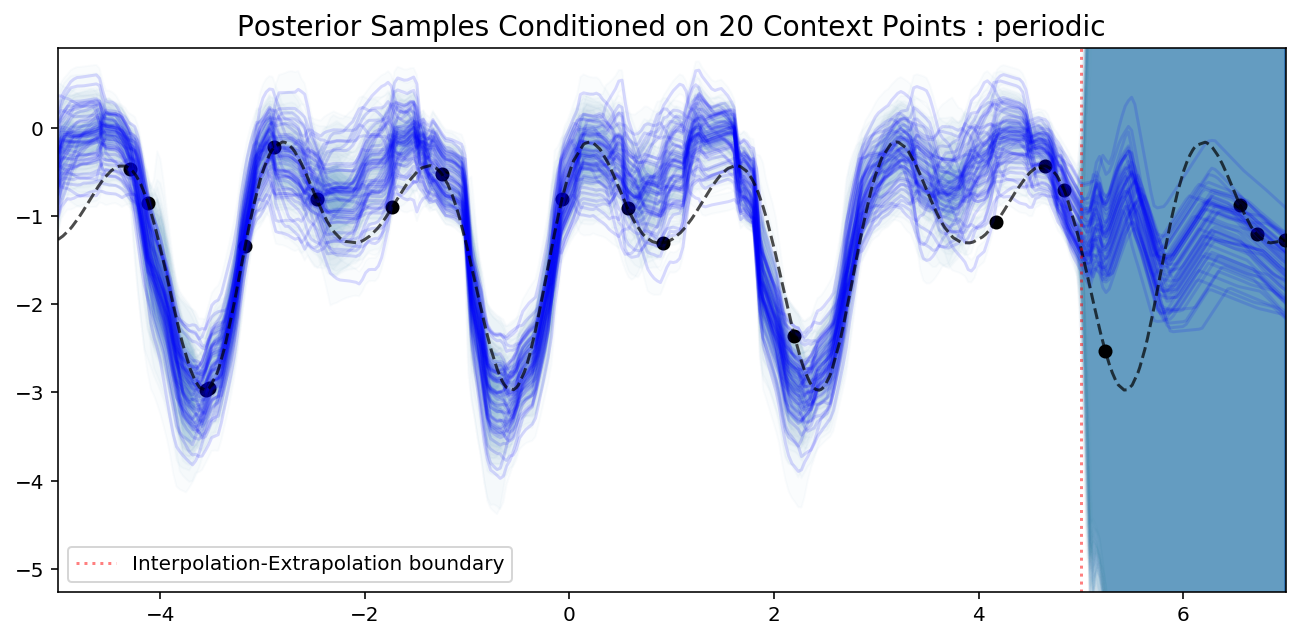

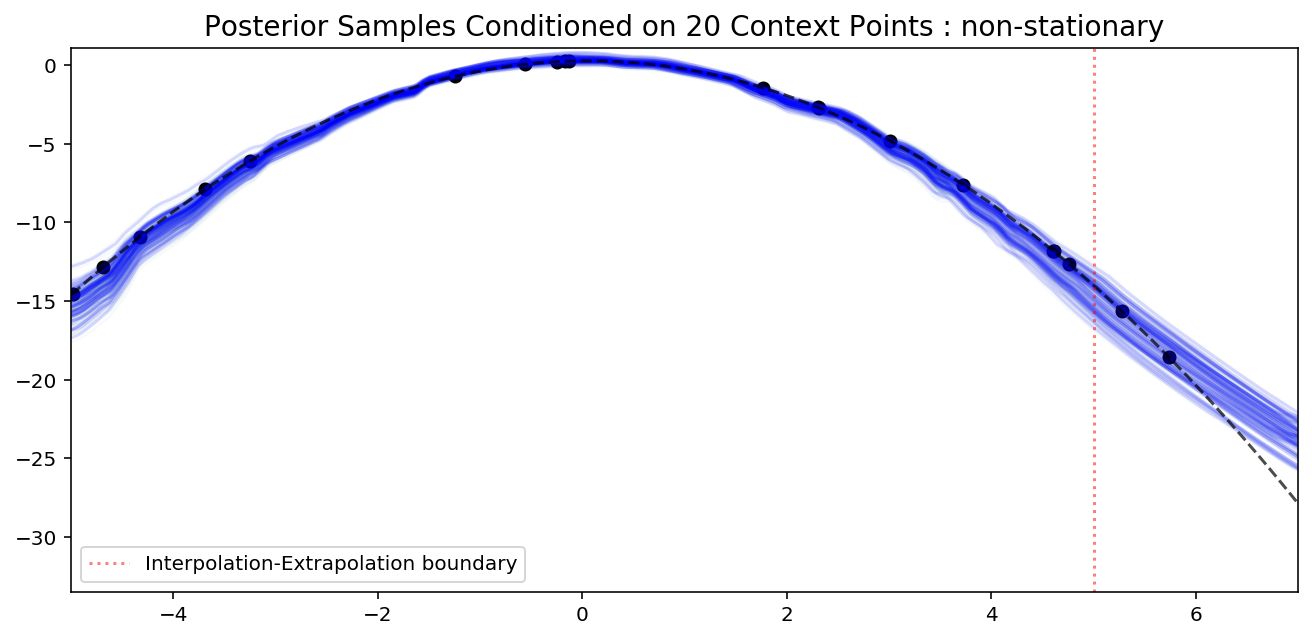

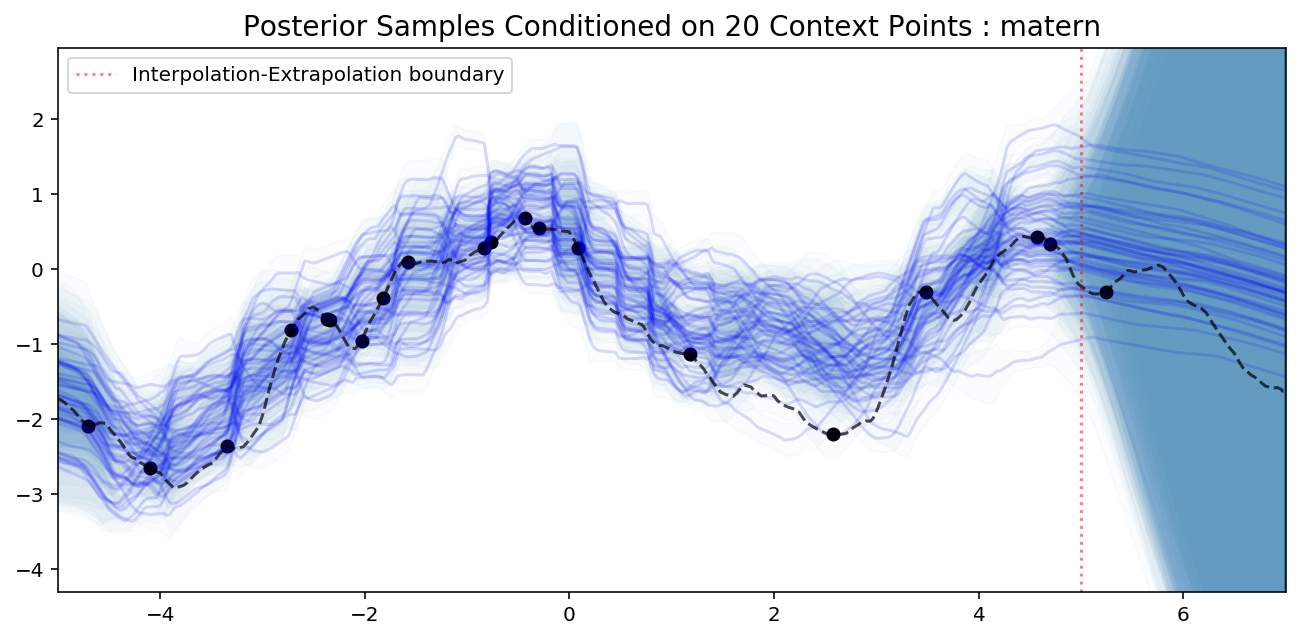

In [19]:
N_CNTXT = 20
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=3*N_POINTS,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

We see that the predictions are not great.

**Good**:
- Uncertainty at extrapolation is very good (besides for non stationary kernel, but it extrapolates well for this one so fine)

**Bad**:
- it underfits and the mean does not often pass through the context points 
- the samples don't seem to be really different from each other but rather shifted (i.e. different z seem to give a linear shift in y and x)